# Imports

In [1]:
import tensorflow as tf  
import torch  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns   
from sklearn.model_selection import train_test_split  
from torch.utils.data import DataLoader, TensorDataset  
from tqdm import tqdm  
from torch.nn import CrossEntropyLoss  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report  
from transformers import BertTokenizer, BertForSequenceClassification, TFBertForSequenceClassification, AdamW  
import json  
from itertools import islice  
import nltk  
import spacy  
import re  
from nltk.corpus import stopwords  
from nltk.stem import PorterStemmer  
from nltk.tokenize import word_tokenize  
import numpy as np   
from deepmultilingualpunctuation import PunctuationModel  
import os
from openai import AzureOpenAI

C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead

# Read Data

In [2]:
train_data = "../standford_questioner_dataset/train-v1.1.json"
test_data = "../standford_questioner_dataset/dev-v1.1.json"

# Preprocessing

In [3]:
# This method is used to extract the question and answer from the json file
def extract_qa(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    records = []
    for item in data['data']:
        for paragraph in item['paragraphs']:
            for qa in paragraph['qas']:
                question = qa['question']
                text = qa['answers'][0]['text'] if qa['answers'] else ''
                record = {'question': question, 'text': text}
                records.append(record)
    df = pd.DataFrame.from_records(records)
    df = df.rename(columns={'text': 'answer'})
    return df


In [4]:
# Read the json file and return a pandas dataframe
df = extract_qa(train_data)

In [5]:
df.shape

(87599, 2)

In [6]:
df.describe()

,question,answer
count,87599,87599
unique,87355,65134
top,Who won this season of Idol?,three
freq,6,233


In [7]:
df.head()

,question,answer
0,To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous
1,What is in front of the Notre Dame Main Building?,a copper statue of Christ
2,The Basilica of the Sacred heart at Notre Dame...,the Main Building
3,What is the Grotto at Notre Dame?,a Marian place of prayer and reflection
4,What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary


In [8]:
nltk.download('stopwords')  
nltk.download('punkt')  
nlp = spacy.load('en_core_web_sm')  
punctuation_model = PunctuationModel(model='oliverguhr/fullstop-punctuation-multilang-large')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jegullin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jegullin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\pipelines\token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="none"` instead.
  warnings.warn(


In [9]:
def preprocess(data):  
    # This method should remove any html tags in the data
    # remove html tags
    data = re.sub(r'<.*?>', '', data)
    # Restore punctuations
    # data = punctuation_model.restore_punctuation(data)
    # spelling correction
    # spell = SpellCorrector()
    # data = ' '.join([spell.correct(token) for token in data.split()])

    return data

#create a new dataframe with the preprocessed data
df['question'] = df['question'].apply(preprocess)
df['answer'] = df['answer'].apply(preprocess)


In [10]:
# Data after preprocessing
pd.set_option('display.max_colwidth', -1)
df.head(10)

C:\Users\jegullin\AppData\Local\Temp\ipykernel_37436\2582630244.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,question,answer
0,To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,Saint Bernadette Soubirous
1,What is in front of the Notre Dame Main Building?,a copper statue of Christ
2,The Basilica of the Sacred heart at Notre Dame is beside to which structure?,the Main Building
3,What is the Grotto at Notre Dame?,a Marian place of prayer and reflection
4,What sits on top of the Main Building at Notre Dame?,a golden statue of the Virgin Mary
5,When did the Scholastic Magazine of Notre dame begin publishing?,September 1876
6,How often is Notre Dame's the Juggler published?,twice
7,What is the daily student paper at Notre Dame called?,The Observer
8,How many student news papers are found at Notre Dame?,three
9,In what year did the student paper Common Sense begin publication at Notre Dame?,1987


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cpu


# RAG

In [12]:
endpoint = os.getenv("ENDPOINT_URL", "https://gjeevanmai.openai.azure.com/")
deployment = os.getenv("DEPLOYMENT_NAME", "gpt-35-turbo")
search_endpoint = os.getenv("SEARCH_ENDPOINT", "https://searchservicegj.search.windows.net")
search_key = os.getenv("SEARCH_KEY", "")
search_index = os.getenv("SEARCH_INDEX_NAME", "index1016")
subscription_key = os.getenv("AZURE_OPENAI_API_KEY", "")


In [13]:

# Initialize Azure OpenAI client with key-based authentication
client = AzureOpenAI(
    azure_endpoint=endpoint,
    api_key=subscription_key,
    api_version="2024-05-01-preview",
)

# Conversational Chat bot on the RAG data

In [14]:
# Conversational Chat bot using RAG Azure open ai search
def conversational_rag_bot(prompt):
    # Prepare the chat prompt
    chat_prompt = [
        {
            "role": "system",
            "content": "You are an AI assistant for the Stanford University that helps people find information."
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    # Include speech result if speech is enabled
    speech_result = chat_prompt

    # Generate the completion
    completion = client.chat.completions.create(
        model=deployment,
        messages=speech_result,
        # past_messages=10,
        max_tokens=800,
        temperature=0.7,
        top_p=0.95,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None,
        stream=False
    )

    # Return the completion
    return completion.choices[0].message.content



In [15]:
# Test the conversational chat bot in the loop until the user types "exit"
while True:
    # Get the user input
    user_input = input("You: ")
    print("User input:", user_input)
    # Check if the user wants to exit
    if user_input.lower() == "exit":
        break

    # Get the response from the conversational chat bot
    response = conversational_rag_bot(user_input)

    # Print the response
    print("Bot:", response)



User input: Hi
Bot: Hello! How can I assist you today?
User input: 
Bot: Hello! How can I assist you today? If you have any questions or need help with anything related to Stanford University, feel free to ask.
User input: How many students in total were at Notre Dame in 2014?
Bot: In 2014, the total enrollment at the University of Notre Dame was approximately 12,179 students. This figure includes undergraduate and graduate students.
User input: What did the Science Hall at Notre Dame come to be known as?
Bot: The Science Hall at Notre Dame came to be known as LaFortune Student Center. It is a student activity center at the University of Notre Dame in Indiana, USA.
User input: How many years was Knute Rockne head coach at Notre Dame?
Bot: Knute Rockne was the head coach at Notre Dame for 13 years, from 1918 to 1930. During his tenure, he achieved great success and is considered one of the most influential coaches in college football history.
User input: What was the lifespan of Theodor

# RAG Chatbot from the web UI

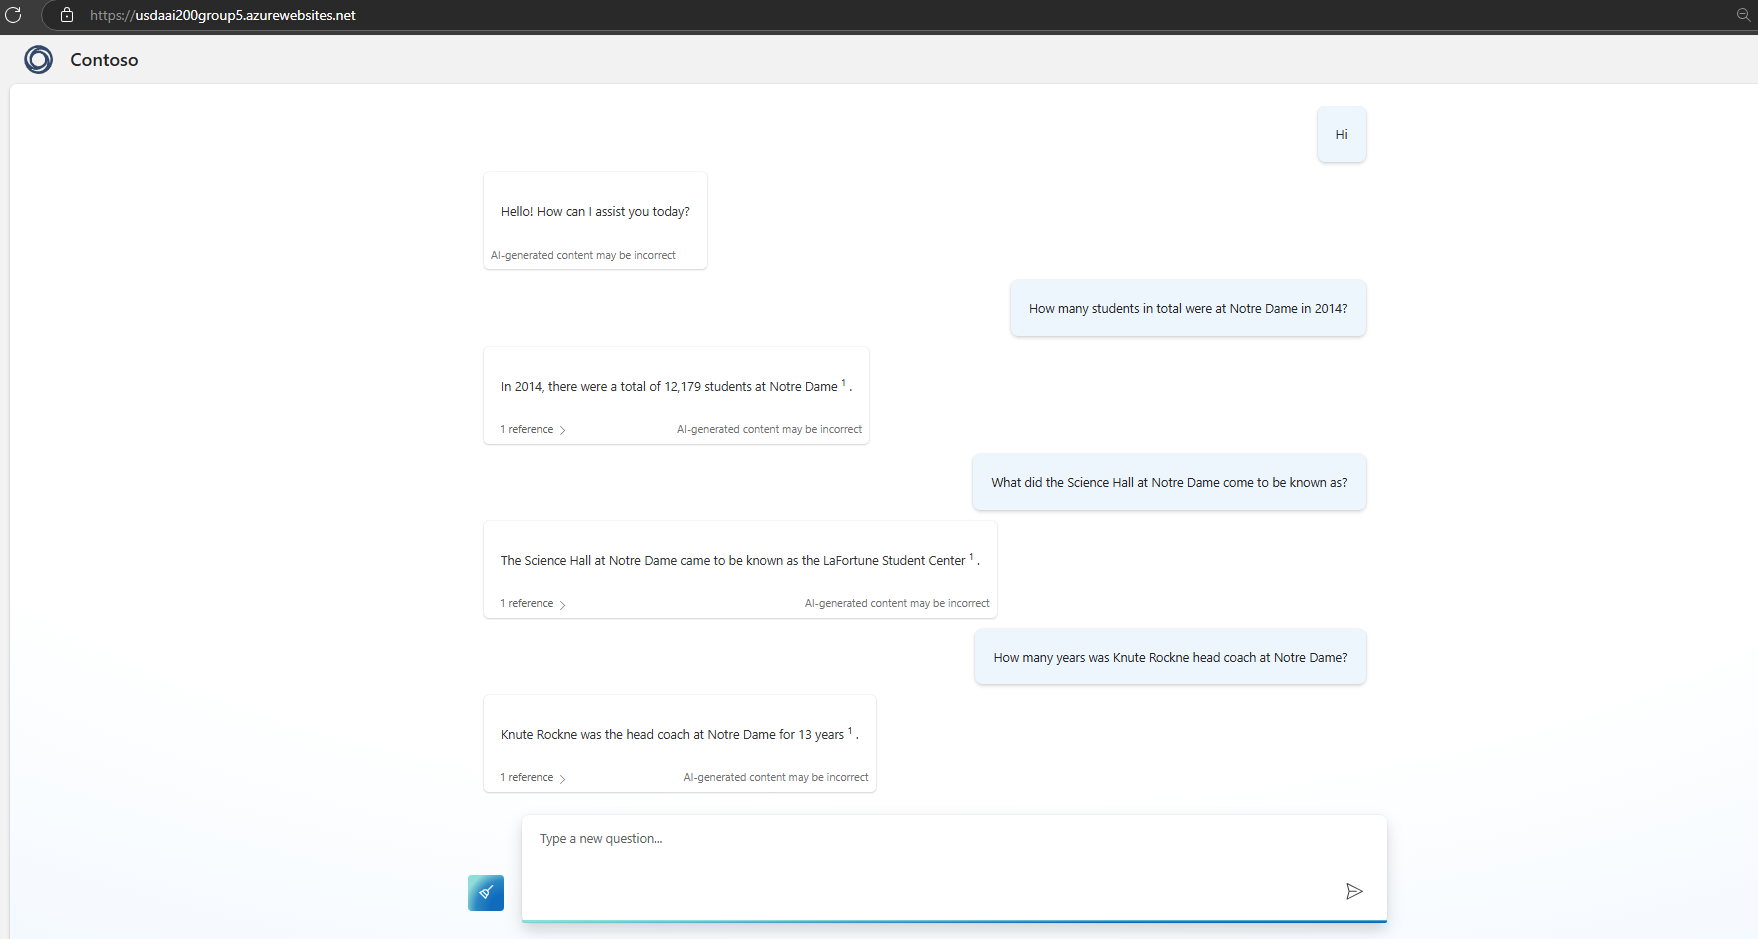

# Evaluation of the Model

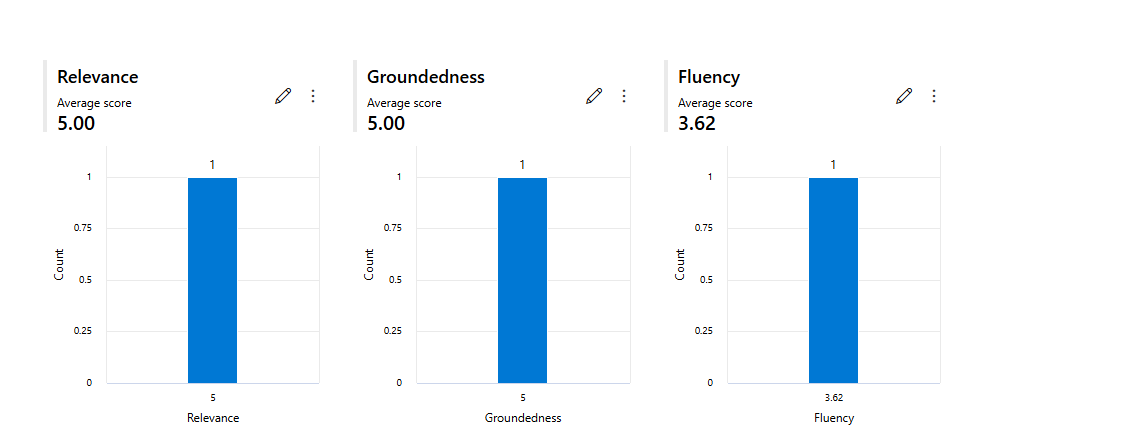